In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from langdetect import detect
from googletrans import Translator
import re

import nltk
from nltk import word_tokenize
# nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib

Create Function for Tect Cleaning

In [16]:
# Function for Parts of Speech Tagging to Improve Lemmatization output in text_processing function
def get_wordnet_pos(pos_tagger):
    if pos_tagger.startswith('J'):
        return wordnet.ADJ
    elif pos_tagger.startswith('V'):
        return wordnet.VERB
    elif pos_tagger.startswith('N'):
        return wordnet.NOUN
    elif pos_tagger.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Use NOUN as the default tag


def text_processing(review):
    # translate review to english if detected language is not english
    translator = Translator() 
    if detect(review) != "en":
        review = translator.translate(review, dest="en").text
    
    # change all reviews into lower case
    review = review.lower()
    
    #remove all new line and tab character, as well as split words joined with hyphen into two(2)
    review = review.replace("\n", " ").replace("\t", " ").replace("-", " ").replace("show", "")
    
    #remove all punctuations
    review = re.sub(r'[^\w\s]', ' ', review)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    
    #tokenize text
    tokens = word_tokenize(review)
    tokens = [token for token in tokens if token not in stop_words]
    
    #parts of speech tagging
    pos_tags = nltk.pos_tag(tokens)
    
    #lemmatize texts
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word, pos in pos_tags:
        wordnet_tag = get_wordnet_pos(pos)
        lem_word = lemmatizer.lemmatize(word, pos=wordnet_tag)
        lemmatized_words.append(lem_word)
    
    processed_review = " ".join(lemmatized_words)
       
    return processed_review

# build an iterable collection of strings required for TfidfVectorizer for spam_filter_pipeline
def text_preprocessing(rev):
    # function only takes a string or list, dataframe or series of strings
    
    # return a list of clean values for string argument. This is because the TfidfVectorizer
    list_ = []
    
    if type(rev) == str:
        list_ = [text_processing(rev)]
    
    else:
        list_ = [text_processing(i) for i in rev]
    
    return list_

Import file into python

In [3]:
file_path = "/Users/mobolajishobanke/Desktop/GWU - School/EMSE 6586_Database Mgt/Project/Book1.csv"

book1_data = pd.read_csv(file_path)

# check data info:
print(f'{book1_data.info()}\n\nNull_Value Info:\n{book1_data.isnull().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   User Href  1110 non-null   object
 1   Title      1110 non-null   object
 2   Rating     1110 non-null   object
 3   Date       1110 non-null   object
 4   Likes      1110 non-null   object
 5   Comments   1110 non-null   object
 6   Review     1109 non-null   object
dtypes: object(7)
memory usage: 60.8+ KB
None

Null_Value Info:
User Href    0
Title        0
Rating       0
Date         0
Likes        0
Comments     0
Review       1
dtype: int64


In [4]:
# remove null values
book1_data = book1_data.dropna().reset_index(drop=True)

# take sample data for training set
sample = book1_data[['Review']].head(n=100)

Perform Manual labelling of sample reviews to be used for text_classification model

In [5]:
label = [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        ]

# create label columns
sample['spam'] = label

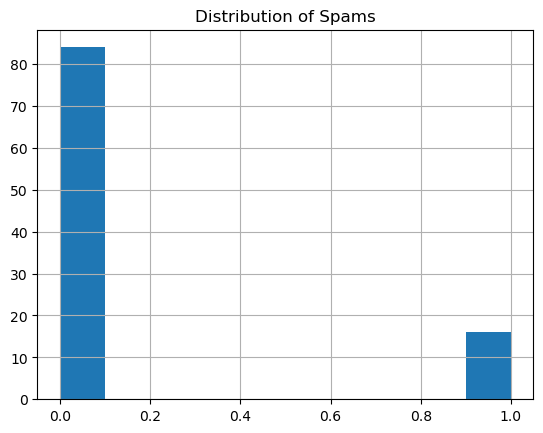

number of spams in the sample: 16
number of not_spams in the sample: 84
Probability of Spam: 0.16


In [9]:
# check distribution of spams and non-spams in the sample dataset
sample['spam'].hist()
plt.title('Distribution of Spams')
plt.show()


print(f'number of spams in the sample: {len(sample[sample.spam==1])}')
print(f'number of not_spams in the sample: {len(sample[sample.spam==0])}')
print(f'Probability of Spam: {len(sample[sample.spam==1])/len(sample)}')

In [96]:
# undersample non_spams to reduce weight bias
index_spam = [index for index, value in enumerate(sample.spam) if value==1]
index_notspam = [index for index, value in enumerate(sample.spam) if value==0]

spam_reviews = sample.loc[index_spam]
not_spamreviews = sample.loc[index_notspam].sample(n=20, random_state=42)

# new sample dataset
underweighted_sample = pd.concat([spam_reviews, not_spamreviews], axis=0).sample(frac=1, ignore_index=True, random_state=42)

## Model Build

In [97]:
# collect reviews
reviews = underweighted_sample['Review']

# collect corresponding labels
spam = underweighted_sample['spam']

Clean and Vectorize Reviews

In [98]:
reviews_clean = reviews.apply(lambda x: text_processing(x))

# create vectorizer object
vectorizer = TfidfVectorizer()

# vectorize cleaned review
review_vec = vectorizer.fit_transform(reviews_clean)

Define Models to be used for task

In [99]:
# Logistic Regression
lr = LogisticRegression(class_weight = 'balanced')

# Support Vector Classifier
svc = SVC(kernel = 'sigmoid', class_weight = 'balanced', probability=True)

Check Performance of Both Classifiers

Select best model using KFold and Cross_Validation

total size of underwighted sample = 36

number of Fold = 5 (such that train_set = 4 out 5 = 80%)

In [101]:
score_lr = cross_val_score(lr, review_vec, spam, scoring='f1', cv=5)
score_svc = cross_val_score(svc, review_vec, spam, scoring='f1', cv=5)

print('score for LogisticRegression: \n{}'.format(score_lr))
print('mean_score for logisticRegression: {}\n'.format(score_lr.mean()))
print('score for SVC: \n{}'.format(score_svc))
print('mean_score for SVC: {}'.format(score_svc.mean()))

score for LogisticRegression: 
[0.66666667 0.4        0.5        1.         0.66666667]
mean_score for logisticRegression: 0.6466666666666666

score for SVC: 
[0.85714286 0.66666667 0.5        1.         0.5       ]
mean_score for SVC: 0.7047619047619047


In [102]:
# select best model using KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# save performance metrics for logistic regression
model_lr = []
f1_score_lr = []
confusion_matrix_lr = []

# save performance metrics for SVC
model_svc = []
f1_score_svc = []
confusion_matrix_svc = []

for i, (train_data, test_data) in enumerate(kfold.split(underweighted_sample)):
    # split the data into train_test_split
    x_train, y_train = review_vec[train_data], spam[train_data]
    x_test, y_test = review_vec[test_data], spam[test_data]
    
    # fit both classififiers
    lr.fit(x_train, y_train)
    svc.fit(x_train, y_train)
    
    #save models for both classifier
    model_lr.append(lr)
    model_svc.append(svc)
    
    # predict test set
    spam_pred_lr = lr.predict(x_test)
    spam_pred_svc = svc.predict(x_test)
    
    # save f1_score for both models
    f1_score_lr.append(f1_score(y_test, spam_pred_lr))
    f1_score_svc.append(f1_score(y_test, spam_pred_svc))
    
    # confusion matrix for both models
    confusion_matrix_lr.append(confusion_matrix(y_test, spam_pred_lr))
    confusion_matrix_svc.append(confusion_matrix(y_test, spam_pred_svc))
    
print("f1_score for LogisticRegression:\n{}\n".format(f1_score_lr))
print("f1_score for SVC:\n{}".format(f1_score_svc))

f1_score for LogisticRegression:
[0.28571428571428575, 0.3333333333333333, 0.0, 0.8571428571428571, 0.6666666666666666]

f1_score for SVC:
[0.5, 0.3333333333333333, 0.0, 0.75, 0.6666666666666666]


Check for Overfitting in the models using cross_val_score

In [106]:
mean_f1_score_lr = np.mean(f1_score_lr)
mean_f1_score_svc = np.mean(f1_score_svc)

mean_f1_score_lr, mean_f1_score_svc

(0.42857142857142855, 0.45)

Curse of Dimensionality

- Reduce Dimensionality using PCA of Review Vectors to Reduce Potential Overfitting

In [109]:
# create PCA object
pca = PCA()

# determine the number of components - # fit the pca
pca.fit(review_vec.toarray())

# obtain eigenvalue
explained_variance = pca.explained_variance_

Plot Screeplot

Mean EigenValue: 0.024662143868574134
Maximum EigenValue: 0.05401915799695827


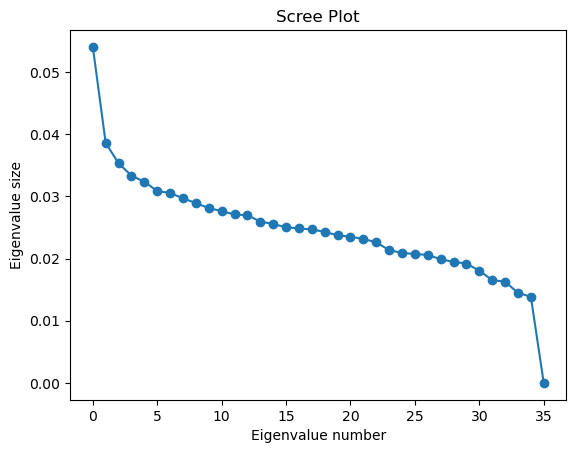

In [118]:
# plot screeplot
plt.plot(explained_variance, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

print("Mean EigenValue: {}".format(explained_variance.mean()))
print("Maximum EigenValue: {}".format(max(explained_variance)))

Maximum EigenValue < 1. Therefore Kaiser Rule can't be used

Use number of principal components that explain 90% of the variance in the dataset

In [121]:
# find cumulative variance rato
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# find the number of components needed to explain at least 95% of the variance
n_component = np.argmax(cumulative_var_ratio >= 0.95) + 1

pca = PCA(n_components = n_component)

dimen_red_review_vec = pca.fit_transform(review_vec.toarray())

score_lr_pca = cross_val_score(lr, dimen_red_review_vec, spam, scoring='f1', cv=5)
score_svc_pca = cross_val_score(svc, dimen_red_review_vec, spam, scoring='f1', cv=5)

In [124]:
score_lr_pca.mean(), score_svc_pca.mean()

(0.7, 0.680952380952381)

Conclusion:

- F1_score for Logistic Regression Increased
- F1_score for SVC reduced slightly

In [ ]:
score_svc_pca

array([0.66666667, 0.66666667, 0.5       , 1.        , 0.57142857])